# Load

In [94]:
# --- Cell 1: Import & Load Images ---
import cv2, numpy as np, matplotlib.pyplot as plt, os

# Đọc ảnh cho từng phần
img_input  = cv2.imread('input/teddy-frame10.png', cv2.IMREAD_GRAYSCALE)
img_left   = cv2.imread('input/frame10.png',  cv2.IMREAD_GRAYSCALE)
img_right  = cv2.imread('input/frame11.png', cv2.IMREAD_GRAYSCALE)
imgs_pano  = [cv2.imread(f'input/redcanyon-00{i}.JPG') for i in range(42,46) if os.path.exists(f'input/redcanyon-00{i}.JPG')]

# Kiểm tra
print("Loaded:",
      f"\n  input:  {img_input is not None}",
      f"\n  stereo:    {img_left is not None and img_right is not None}",
      f"\n  pano imgs: {len(imgs_pano)}")


Loaded: 
  input:  True 
  stereo:    True 
  pano imgs: 4


# A

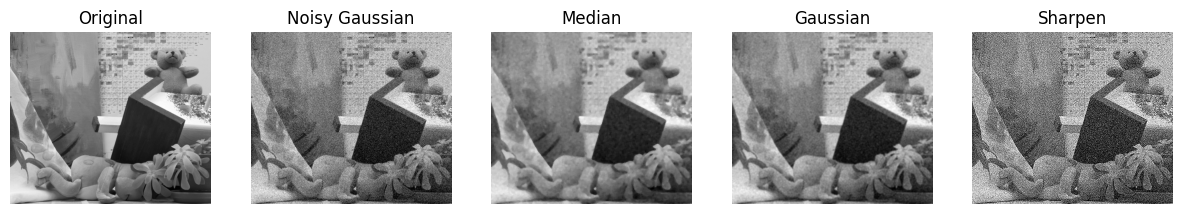


--- Noise: Gaussian ---
Mean             PSNR=27.24  GradSim=0.400
Gaussian         PSNR=28.76  GradSim=0.641
Median           PSNR=27.85  GradSim=0.574
LaplacianSharpen PSNR=11.34  GradSim=-9.239


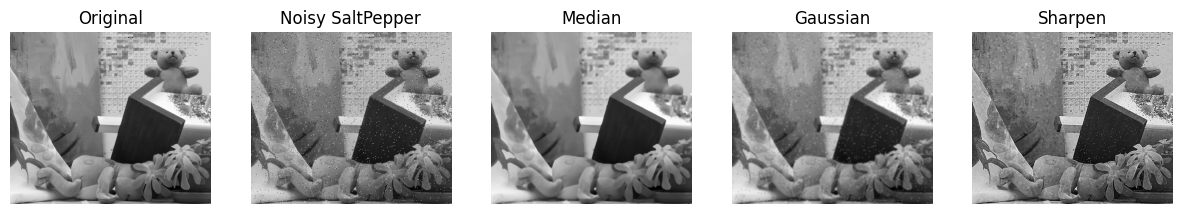


--- Noise: SaltPepper ---
Mean             PSNR=27.20  GradSim=0.388
Gaussian         PSNR=28.77  GradSim=0.622
Median           PSNR=29.63  GradSim=0.707
LaplacianSharpen PSNR=17.94  GradSim=-0.956


In [95]:
def imshow_grid_A(imgs, titles=None, cmap='gray', figsize=(12,4)):
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs):
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(im, cmap=cmap)
        if titles: plt.title(titles[i])
        plt.axis('off')
    plt.show()

def PSNR_A(a, b):
    mse = np.mean((a.astype(np.float32) - b.astype(np.float32))**2)
    if mse == 0: return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))

def grad_sim_A(a, b):
    gx_a = cv2.Sobel(a, cv2.CV_32F, 1, 0, 3)
    gy_a = cv2.Sobel(a, cv2.CV_32F, 0, 1, 3)
    gx_b = cv2.Sobel(b, cv2.CV_32F, 1, 0, 3)
    gy_b = cv2.Sobel(b, cv2.CV_32F, 0, 1, 3)
    ga, gb = np.sqrt(gx_a**2+gy_a**2), np.sqrt(gx_b**2+gy_b**2)
    mse = np.mean((ga-gb)**2)
    return 1 - mse/(np.var(ga)+1e-8)

def partA_image_filtering(img_gray):
    base = img_gray
    # Noise
    gauss = np.clip(base + np.random.normal(0,20,base.shape),0,255).astype(np.uint8)
    sp = base.copy(); rnd = np.random.rand(*base.shape)
    sp[rnd<0.01]=0; sp[rnd>0.99]=255
    noises = {'Gaussian': gauss, 'SaltPepper': sp}
    results = {}

    for nname, noisy in noises.items():
        mean_ = cv2.blur(noisy,(5,5))
        gauss_ = cv2.GaussianBlur(noisy,(5,5),0)
        median_ = cv2.medianBlur(noisy,5)
        lap = cv2.Laplacian(noisy,cv2.CV_32F); sharp = np.clip(noisy - 0.7*lap,0,255).astype(np.uint8)
        filters = {'Mean':mean_,'Gaussian':gauss_,'Median':median_,'LaplacianSharpen':sharp}
        table = {k:(PSNR_A(base,v),grad_sim_A(base,v)) for k,v in filters.items()}
        results[nname]={'noisy':noisy,'filters':filters,'metrics':table}

        imshow_grid_A([base,noisy,median_,gauss_,sharp],
                      ['Original',f'Noisy {nname}','Median','Gaussian','Sharpen'],figsize=(15,4))
        print(f"\n--- Noise: {nname} ---")
        for k,(p,s) in table.items():
            print(f"{k:16s} PSNR={p:.2f}  GradSim={s:.3f}")

    return results

resA = partA_image_filtering(img_input)

# B

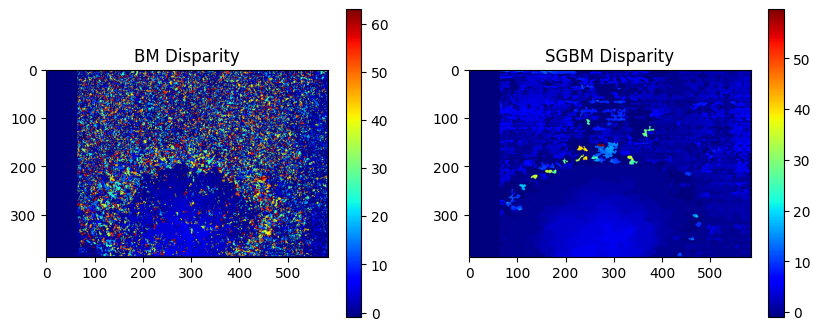

Saved PLYs: BM=94010 pts, SGBM=114701 pts


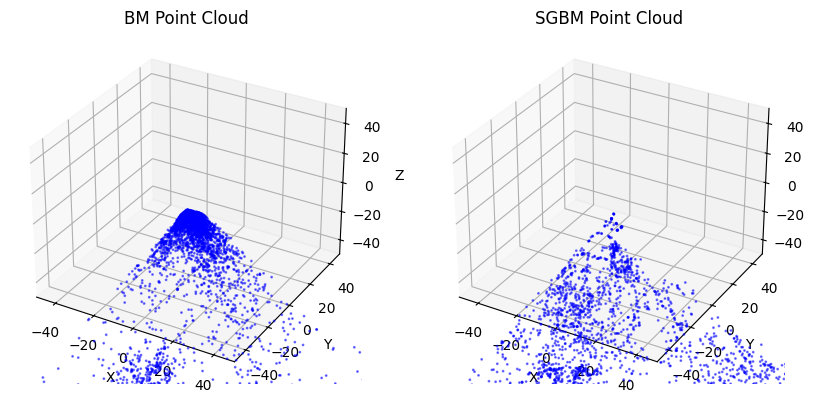

Fundamental Matrix:
[[ 4.22856206e-07  7.78119256e-04 -2.36508394e-01]
 [-7.75802562e-04  1.09299279e-06  4.76657454e-02]
 [ 2.35846059e-01 -5.13021382e-02  1.00000000e+00]]


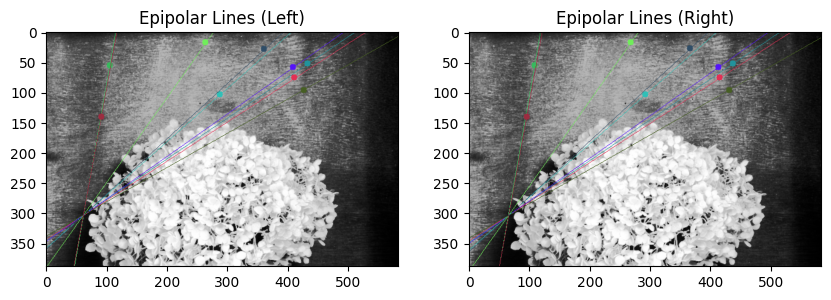

In [116]:
# --- Part B: 3D Reconstruction (BM + SGBM + Epipolar Lines) ---
def partB_3D_full(img_left, img_right):
    """
    --- Explanation (Part B) ---
    Stereo matching finds the horizontal shift (disparity) between 
    corresponding pixels in the left and right rectified images.
    The closer the object, the larger the disparity value.
    BM (Block Matching) compares fixed-size blocks directly.
    SGBM (Semi-Global Block Matching) refines disparity by minimizing
    a global cost function, producing smoother and more accurate results.
    The disparity map is then reprojected into 3D coordinates using matrix Q.
    """
    imgL = cv2.equalizeHist(img_left)
    imgR = cv2.equalizeHist(img_right)

    # --- Disparity: BM ---
    bm = cv2.StereoBM_create(numDisparities=64, blockSize=5)
    disp_bm = bm.compute(imgL, imgR).astype(np.float32) / 16.0

    # --- Disparity: SGBM ---
    sgbm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=64,
        blockSize=5,
        P1=8 * 3 * 5 ** 2,
        P2=32 * 3 * 5 ** 2,
        disp12MaxDiff=1,
        uniquenessRatio=10,
        speckleWindowSize=50,
        speckleRange=2
    )
    disp_sgbm = sgbm.compute(imgL, imgR).astype(np.float32) / 16.0

    # --- Visualization disparity ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(disp_bm, cmap='jet')
    plt.title('BM Disparity')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(disp_sgbm, cmap='jet')
    plt.title('SGBM Disparity')
    plt.colorbar()
    plt.show()

    # --- Q matrix ---
    h, w = imgL.shape
    f = 0.8 * w
    Q = np.float32([[1, 0, 0, -w / 2],
                    [0, -1, 0, h / 2],
                    [0, 0, 0, -f],
                    [0, 0, 1, 0]])

    # --- Convert disparity to 3D point clouds ---
    pts_bm, clr_bm = disparity_to_pointcloud(disp_bm, imgL, Q)
    pts_sgbm, clr_sgbm = disparity_to_pointcloud(disp_sgbm, imgL, Q)

    save_ply_B('output/pointcloud_BM.ply', pts_bm, clr_bm)
    save_ply_B('output/pointcloud_SGBM.ply', pts_sgbm, clr_sgbm)
    print(f"Saved PLYs: BM={len(pts_bm)} pts, SGBM={len(pts_sgbm)} pts")

    # --- Show 3D scatter ---
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    show_cloud(ax1, pts_bm, "BM Point Cloud")
    show_cloud(ax2, pts_sgbm, "SGBM Point Cloud")
    plt.show()

    # --- Epipolar Geometry ---
    plot_epipolar_lines(imgL, imgR)

    return disp_bm, disp_sgbm, pts_bm, pts_sgbm


# --- Helper: disparity to 3D ---
def disparity_to_pointcloud(disp, img, Q):
    points_3D = cv2.reprojectImageTo3D(disp, Q)
    mask = (disp > disp.min()) & np.isfinite(points_3D[:, :, 2])
    points = points_3D[mask]
    colors = img[mask]
    Z = points[:, 2]
    valid = (Z > -10000) & (Z < 10000)
    return points[valid], colors[valid]


# --- Helper: save point cloud ---
def save_ply_B(filename, verts, colors):
    verts = verts.reshape(-1, 3)
    if colors.ndim == 1:
        colors = np.stack([colors] * 3, axis=1)
    colors = np.clip(colors, 0, 255).astype(np.uint8)
    verts = np.hstack([verts, colors])
    ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''
    with open(filename, 'w') as f:
        f.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d')


# --- Helper: show 3D cloud ---
def show_cloud(ax, pts, title):
    sample = pts[::max(1, len(pts) // 5000)]
    ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2], c='b', s=1, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_xlim([-50, 50]); ax.set_ylim([-50, 50]); ax.set_zlim([-50, 50])


# --- Helper: Epipolar Lines Visualization ---
# --- Helper: Epipolar Lines Visualization (both images) ---
def plot_epipolar_lines(imgL, imgR):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(imgL, None)
    kp2, des2 = sift.detectAndCompute(imgR, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key=lambda x: x.distance)
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Ước lượng Fundamental Matrix
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)
    print(f"Fundamental Matrix:\n{F}")

    # Lọc inlier
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]

    # --- Tính và vẽ epipolar lines cho cả hai ảnh ---
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines1 = lines1.reshape(-1, 3)
    lines2 = lines2.reshape(-1, 3)

    imgL_color = cv2.cvtColor(imgL, cv2.COLOR_GRAY2BGR)
    imgR_color = cv2.cvtColor(imgR, cv2.COLOR_GRAY2BGR)

    # Giới hạn hiển thị 10 cặp để dễ quan sát
    for r1, r2, pt1, pt2 in zip(lines1[:10], lines2[:10], pts1[:10], pts2[:10]):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        # Epipolar line bên trái
        x0, y0 = map(int, [0, -r1[2] / r1[1]])
        x1, y1 = map(int, [imgL.shape[1], -(r1[2] + r1[0] * imgL.shape[1]) / r1[1]])
        imgL_color = cv2.line(imgL_color, (x0, y0), (x1, y1), color, 1)
        imgL_color = cv2.circle(imgL_color, tuple(np.int32(pt1)), 5, color, -1)

        # Epipolar line bên phải
        x0, y0 = map(int, [0, -r2[2] / r2[1]])
        x1, y1 = map(int, [imgR.shape[1], -(r2[2] + r2[0] * imgR.shape[1]) / r2[1]])
        imgR_color = cv2.line(imgR_color, (x0, y0), (x1, y1), color, 1)
        imgR_color = cv2.circle(imgR_color, tuple(np.int32(pt2)), 5, color, -1)

    plt.figure(figsize=(10, 4))
    plt.subplot(121); plt.imshow(imgL_color[..., ::-1]); plt.title("Epipolar Lines (Left)")
    plt.subplot(122); plt.imshow(imgR_color[..., ::-1]); plt.title("Epipolar Lines (Right)")
    plt.show()


# --- Run ---
disp_bm, disp_sgbm, pts_bm, pts_sgbm = partB_3D_full(img_left, img_right)


# C

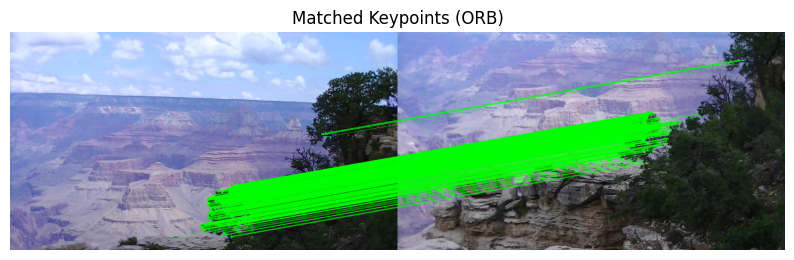

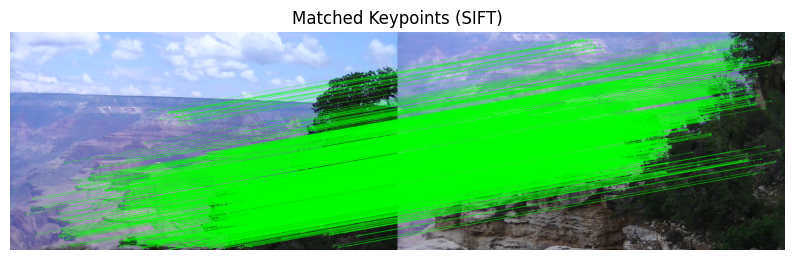

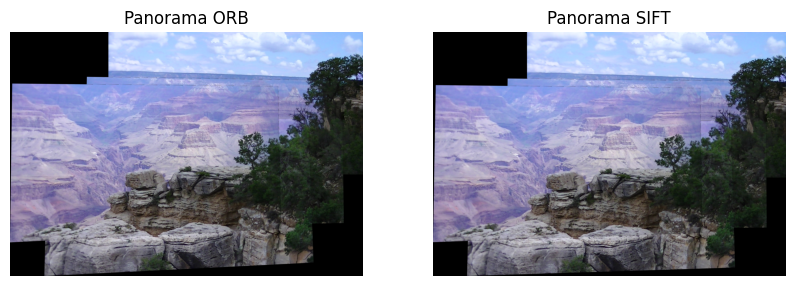

In [ ]:
def match_and_homography(img1, img2, detector='ORB'):
    """
    --- Explanation (Part C) ---
    The Fundamental Matrix (F) defines the relationship between corresponding 
    points in two stereo images:  x'^T * F * x = 0.
    For any point in one image, its corresponding point in the other image 
    must lie on an epipolar line defined by F.
    This ensures geometric consistency between stereo pairs.
    """
    if detector == 'SIFT':
        det = cv2.SIFT_create()
        norm = cv2.NORM_L2
    else:
        det = cv2.ORB_create(2000)
        norm = cv2.NORM_HAMMING

    # Detect keypoints and descriptors
    kp1, des1 = det.detectAndCompute(img1, None)
    kp2, des2 = det.detectAndCompute(img2, None)

    # Match features
    matcher = cv2.BFMatcher(norm)
    matches = matcher.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    if len(good) < 4:
        return None, None, [], kp1, kp2

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Homography with RANSAC
    H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    return H, mask, good, kp1, kp2

def stitch_images(imgs, detector='ORB'):
    pano = imgs[0]
    for i in range(1, len(imgs)):
        img_next = imgs[i]
        H, mask, good, kp1, kp2 = match_and_homography(pano, img_next, detector)
        if H is None:
            print(f"Skipping image {i}: insufficient matches")
            continue

        # --- Visualization: matched keypoints ---
        if i == 1:  # visualize only once
            matched_vis = draw_matches(pano, img_next, kp1, kp2, good, mask)
            plt.figure(figsize=(10,5))
            plt.imshow(cv2.cvtColor(matched_vis, cv2.COLOR_BGR2RGB))
            plt.title(f"Matched Keypoints ({detector})")
            plt.axis('off')
            plt.show()

        # Compute canvas size
        h1, w1 = pano.shape[:2]
        h2, w2 = img_next.shape[:2]
        corners_next = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners_next, H)
        corners = np.concatenate((np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2),
                                 warped_corners), axis=0)

        [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)
        trans = [-xmin, -ymin]

        H_translate = np.array([[1, 0, trans[0]], [0, 1, trans[1]], [0, 0, 1]])
        result = cv2.warpPerspective(img_next, H_translate @ H, (xmax - xmin, ymax - ymin))

        # Simple blending
        mask = (result[trans[1]:h1 + trans[1], trans[0]:w1 + trans[0]] == 0)
        result[trans[1]:h1 + trans[1], trans[0]:w1 + trans[0]][mask] = pano[mask]



        pano = result

    return pano


def draw_matches(img1, img2, kp1, kp2, matches, mask):
    draw_params = dict(matchColor=(0,255,0), singlePointColor=None, matchesMask=mask.ravel().tolist(), flags=2)
    return cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

# ==== Example ====
if len(imgs_pano) < 4:
    print("Need at least 4 images.")
else:
    pano_orb = stitch_images(imgs_pano, 'ORB')
    pano_sift = stitch_images(imgs_pano, 'SIFT')

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(pano_orb, cv2.COLOR_BGR2RGB))
    plt.title('Panorama ORB'); plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(pano_sift, cv2.COLOR_BGR2RGB))
    plt.title('Panorama SIFT'); plt.axis('off')
    plt.show()

